*We will import proccessed na dataset directly to h2o frame*

In [16]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [1]:
import h2o

In [5]:
h2o.init(max_mem_size='6G')

Checking whether there is an H2O instance running at http://localhost:54321. connected.


H2O cluster uptime:,06 secs
H2O cluster version:,3.10.3.4
H2O cluster version age:,1 month and 13 days
H2O cluster name:,H2O_from_python_hamza_jml5au
H2O cluster total nodes:,1
H2O cluster free memory:,5.312 Gb
H2O cluster total cores:,4
H2O cluster allowed cores:,4
H2O cluster status:,"locked, healthy"
H2O connection url:,http://localhost:54321
H2O connection proxy:,None


In [6]:

response = 'IsBadBuy'

# upload data to h2o frame
hdf = h2o.import_file("F:/Don't get kicked/data/train_processed_na.csv")

# factor the class label
hdf[response]= hdf[response].asfactor()

# create train and validation datasets for model learining with 60,20 and 20 percent ratio
hdf_train, hdf_validate, hdf_validate_test = hdf.split_frame(ratios=[0.60,0.2], seed=10)


# create input and response column names

input_name= hdf_train.col_names
input_name.remove(response)
print input_name

Parse progress: |█████████████████████████████████████████████████████████| 100%
[u'PurchDate', u'Auction', u'VehYear', u'VehicleAge', u'Make', u'Model', u'Trim', u'SubModel', u'Color', u'Transmission', u'WheelTypeID', u'WheelType', u'VehOdo', u'Nationality', u'Size', u'TopThreeAmericanName', u'MMRAcquisitionAuctionAveragePrice', u'MMRAcquisitionAuctionCleanPrice', u'MMRAcquisitionRetailAveragePrice', u'MMRAcquisitonRetailCleanPrice', u'MMRCurrentAuctionAveragePrice', u'MMRCurrentAuctionCleanPrice', u'MMRCurrentRetailAveragePrice', u'MMRCurrentRetailCleanPrice', u'PRIMEUNIT', u'AUCGUART', u'BYRNO', u'VNZIP1', u'VNST', u'VehBCost', u'IsOnlineSale', u'WarrantyCost']


In [7]:
def model_performance(model):
    print 'Train accuracy:', model.auc(train=True)
    print 'valid accuracy:', model.auc(valid=True)

    roc_valid = model.roc(valid=True)
    roc_train= model.roc()

    plt.plot(roc_valid[0],roc_valid[1])
    plt.plot(roc_train[0],roc_train[1])
    plt.plot(np.arange(0.0,1.1,0.1),np.arange(0.0,1.1,0.1))
    
    plt.title('ROC Curve')
    plt.legend(['Valid','Train'])
    plt.show()


In [22]:
from h2o.estimators.naive_bayes import H2ONaiveBayesEstimator
from h2o.estimators.gbm import H2OGradientBoostingEstimator

In [14]:
my_nb = H2ONaiveBayesEstimator(seed = 1)
my_nb.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.673140226494
valid accuracy: 0.66759793397


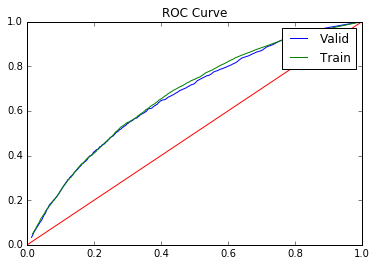

In [17]:
model_performance(my_nb)

In [20]:
my_nb_nfold = H2ONaiveBayesEstimator(seed = 1,
                                     nfolds=25,
                                     fold_assignment="Modulo",
                                     keep_cross_validation_predictions=True,
                                     model_id="my_nb_nfold")
my_nb_nfold.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

naivebayes Model Build progress: |████████████████████████████████████████| 100%


Train accuracy: 0.673140226494
valid accuracy: 0.66759793397


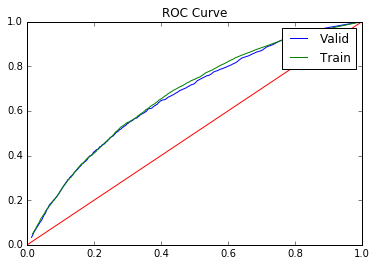

In [21]:
model_performance(my_nb_nfold)

In [31]:
my_gbm = H2OGradientBoostingEstimator(ntrees=30,
                                      max_depth=10,
#                                       min_rows=10,
                                      learn_rate=0.05,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm")
my_gbm.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.929850528806
valid accuracy: 0.719019451112


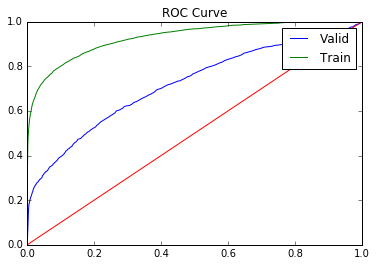

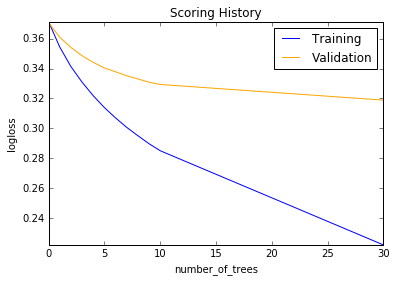

In [32]:
model_performance(my_gbm)
my_gbm.plot()

In [57]:
my_gbm_1 = H2OGradientBoostingEstimator(ntrees=30,
                                      max_depth=5,
#                                       min_rows=5,
                                      learn_rate=0.05,
                                      seed=1,
#                                       overwrite_with_best_model = False,
                                     model_id="my_gbm_1")
my_gbm_1.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.810616925112
valid accuracy: 0.729545273585


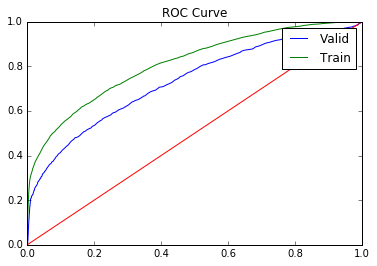

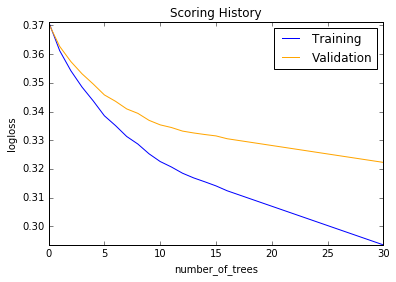

In [58]:
model_performance(my_gbm_1)
my_gbm_1.plot()

In [69]:
my_gbm_nfold = H2OGradientBoostingEstimator(ntrees=250,
                                            max_depth=5,
                                            learn_rate=0.01,
                                            nfolds=7,
                                            fold_assignment="Modulo",
                                            keep_cross_validation_predictions=True,
                                            seed=1,
                                            model_id="my_gbm_nfold")
my_gbm_nfold.train(x = input_name, y = response, training_frame=hdf_train, validation_frame=hdf_validate)

gbm Model Build progress: |███████████████████████████████████████████████| 100%


Train accuracy: 0.827529211304
valid accuracy: 0.734834980476


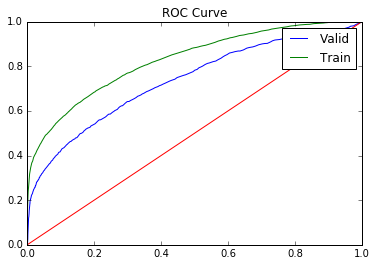

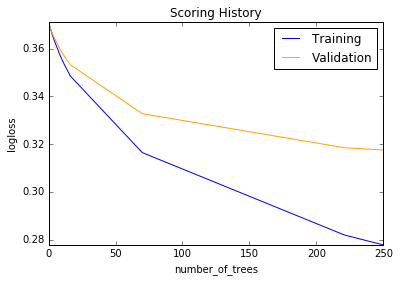

In [70]:
model_performance(my_gbm_nfold)
my_gbm_nfold.plot()

## Predict with test data



In [82]:
import pandas as pd
df_submission = pd.read_csv("F:/Don't get kicked/data/test.csv", usecols= ['RefId'])

In [72]:
hdf_test = h2o.import_file("F:/Don't get kicked/data/test_processed_na.csv")

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [84]:
def get_submission_df(model, data):
#     df_submission = pd.DataFrame()
    prediction = model.predict(data)['predict']

#     df_submission['RefId'] = test_refid
    df_submission['IsBadBuy'] = prediction.as_data_frame()
    
    return df_submission

In [86]:
submission_mygbm1= get_submission_df(my_gbm_1,hdf_test)
submission_mygbm_nfold= get_submission_df(my_gbm_nfold,hdf_test)

gbm prediction progress: |████████████████████████████████████████████████| 100%
gbm prediction progress: |████████████████████████████████████████████████| 100%


In [87]:
submission_mygbm1.to_csv("F:/Don't get kicked/data/submission_mygbm_1.csv", index=False)
submission_mygbm_nfold.to_csv("F:/Don't get kicked/data/submission_mygbm_nfold.csv", index=False)